# Novelty detection

Let's try to detect if the in situ data point are considered as outliers regarding the laboratory cultures. If so, it justify the need to create new category to predict from the in situ data, instead of the dominant taxa.

In [5]:
import pandas as pd

# import lab dataset
lab = pd.read_csv("/home/flavien/Documents/these/mf/Boussole/Data/labo/results_reshape.csv")

#filter data with less than 0.2 chla
lab_conc = lab[lab['chla_conc_spectro'] > 0.2]

#select the cols we want
lab_sel = lab_conc[["440nm_mean", "470nm_mean", "532nm_mean", "strain", "replicate"]]

#remove the NaN
lab_sel = lab_sel.dropna()

#rename columns to make it easier to work with
lab_sel = lab_sel.rename(columns = {"440nm_mean": "f440",
                                    "470nm_mean": "f470",
                                    "532nm_mean": "f532"})

#compute the ratio between each excitation channel
lab_sel = lab_sel.assign(f440_f470 = lambda x: x['f440']/x['f470'],
                f532_f470 = lambda x: x['f532']/x['f470'],
                f532_f440 = lambda x: x['f532']/x['f440'])

#add common names
def categorise(row):
    if row["strain"] in ["RCC1717", "RCC76", "RCC4213"]:
        return "Diatom"
    elif row["strain"] in ["RCC162", "RCC156", "PCC9511"]:
        return "Prochlorococcus"
    elif row["strain"] in ["RCC2379", "RCC2374", "RCC2319"]:
        return "Synechococcus"
    elif row["strain"] == "RCC100":
        return "Pelagophyte"
    elif row["strain"] == "RCC3006":
        return "Dino" 

lab_sel["common_name"] = lab_sel.apply(lambda row: categorise(row), axis = 1)

lab_sel = lab_sel[lab_sel["common_name"] != "Dino"]

In [4]:
#import insitu dataset

insitu = pd.read_csv("/home/flavien/Documents/these/mf/Boussole/Output/Data/Compiled/hplc_mf_clusterised.csv")


In [36]:
#create learning and testing descriptors and target
#learning descriptors
x_lab = lab_sel[["f440_f470", "f532_f470"]]
#testing descriptors
x_insitu = insitu[["f440_f470", "f532_f470"]]
#learning target
y_lab = lab_sel["common_name"]

x_lab = x_lab.to_numpy()
x_insitu = x_insitu.to_numpy()

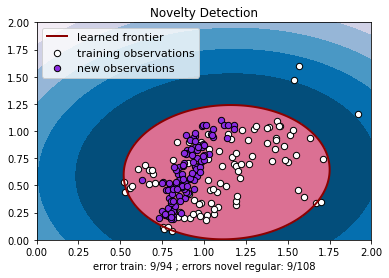

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.svm import OneClassSVM

xx, yy = np.meshgrid(np.linspace(0, 2, 500), np.linspace(0, 2, 500))





# fit the model
clf = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(x_lab)
y_pred_train = clf.predict(x_lab)
y_pred_test = clf.predict(x_lab)

n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size


# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="darkred")
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")

s = 40
b1 = plt.scatter(x_lab[:,0], x_lab[:,1], c="white", s=s, edgecolors="k")
b2 = plt.scatter(x_insitu[:,0], x_insitu[:,1], c="blueviolet", s=s, edgecolors="k")

plt.axis("tight")
plt.xlim((0, 2))
plt.ylim((0, 2))
plt.legend(
    [a.collections[0], b1, b2],
    [
        "learned frontier",
        "training observations",
        "new observations",
    ],
    loc="upper left",
    prop=matplotlib.font_manager.FontProperties(size=11),
)
plt.xlabel(
    "error train: %d/94 ; errors novel regular: %d/108"
    % (n_error_train, n_error_test)
)
plt.show()

In [43]:
len(x_insitu)

108

We can observe that all our insut samples are in the range of the learned area of our SVC model. However, the spread is significantly less important. Thus we can expect bad prediction.
